# Copule et chaîne de Markov

Dans cette feuille, on s'intéresse à la simulation de vecteurs aléatoires. 

- Dans la première partie on simule un vecteur $(\tau_1, \dots, \tau_n)$ dont la dépendance entre les composantes est donnée par une fonction copule, on parle de dépendance spatiale. 
- Dans la deuxième partie, on simule un vecteur $(X_0, \dots, X_n)$ dont la dépendance est temporelle, c'est à dire qu'on construit $X_{k+1}$ à partir de $X_k$ et d'un aléa indépendant. C'est un exemple de chaîne de Markov.

## Copule Gaussienne et instants de défaut

On considère la modélisation suivante: soit $\tau_1, \dots, \tau_n$ des variables aléatoires exponentielles de paramètre $\lambda_i > 0$ qui représentent $n$ instants de défaut (instant de défaillance d'un composant en fiabilité, instant de défaut d'une entreprise en finance, instant de mutation en biologie, etc). On suppose que ces $n$ instants sont corrélés par la copule Gaussienne $C$ de matrice de covariance $\Sigma_{i,i} = 1$ et $\Sigma_{i,j} = \rho \in [0,1]$ pour $i \neq j$. 

Dans un premier temps on s'intéresse à la simulation du vecteur $U = (U_1,\dots,U_n)$ correspondant à la copule $C$ i.e. pour tout $i \in \{1,\dots,n\}, U_i \sim \mathcal{U}([0,1])$ et $C(u_1,\dots,u_n) = \mathbf{P}[U_1 \le u_1,\dots,U_n\le u_n]$. On peut montrer que $U$ se représente sous la forme 

$$
    \forall i \in \{1,\dots,n\}, \quad U_i = \Phi\bigl(\sqrt{\rho} G_0 + \sqrt{1 - \rho} G_i \bigr),
$$

où $(G_0,G_1,\dots, G_n)$ est un vecteur normal standard de $\mathbf{R}^{n+1}$ et $\Phi$ est la fonction de répartition gaussienne standard (fonction `norm` dans le module `scipy.stats`). 

In [1]:
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
# import seaborn as sns
# sns.set_theme() 
from numpy.random import default_rng
rng = default_rng()

### Question: simulation de la copule gaussienne

Ecrire une fonction qui prend 3 arguments: `size`, `n` et `rho` et qui renvoie un échantillon de taille `size` de réalisations $(U_1,\dots,U_n)$ obtenues par la construction précédente.  
Dans toute la suite `n` est la dimension de la copule qui sera par exemple 10, et non le nombre de réalisations considérées. 

In [2]:
def copule_gauss(size : int, n : int, rho : float):
    G = rng.standard_normal(size=(n+1,size))
    U = stats.norm.cdf(np.sqrt(rho)*G[0] + np.sqrt(1-rho)*G[1:])
    return U

### Question: représentation de la copule gaussienne 

Reproduire le tracé suivant à partir d'échantillons $\big(U_1^{(j)}, U_2^{(j)}\big)_{1 \le j \le M}$ de taille $M = 2000$ de réalisations de la copule gaussienne en dimension 2 et de corrélation $\rho= 0.2$ puis $\rho = 0.8$. Que remarquez-vous?  

Compléter ce tracé en vérifiant graphiquement que la loi empirique de chaque composante $\big(U_i^{(j)}\big)_{1 \le j \le M}$ pour $i=1,2$ est proche de la loi uniforme sur $[0,1]$. Vous pouvez augmenter la taille de $M$.

![](img/copula.png)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


/tmp/ipykernel_9549/3475434443.py:20: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


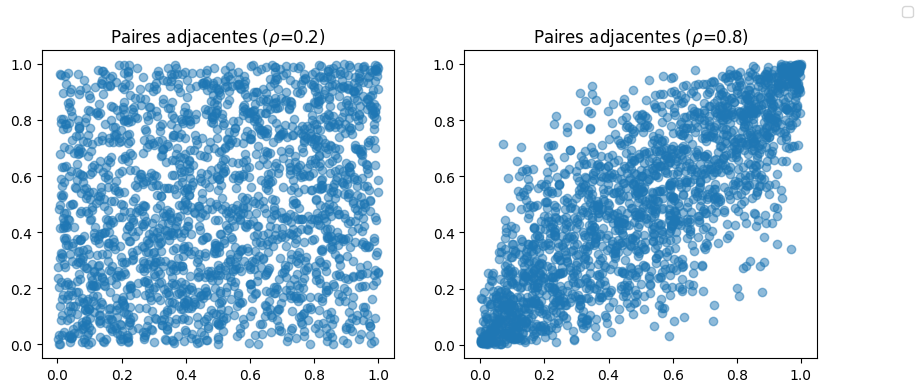

In [3]:
# paramètres
M = 2000
dim = 2
rho1 = 0.2
rho2 = 0.8

# realisation des copules
sample_u_copule1 = copule_gauss(M, dim, rho1)
sample_u_copule2 = copule_gauss(M, dim, rho2)

fig, axs = plt.subplots(1,2, figsize=(10,4))

axs[0].scatter(sample_u_copule1[:-1], sample_u_copule1[1:], alpha=0.5)
axs[0].set_title(fr'Paires adjacentes ($\rho$={rho1})')

axs[1].scatter(sample_u_copule2[:-1], sample_u_copule2[1:], alpha=0.5)
axs[1].set_title(fr'Paires adjacentes ($\rho$={rho2})')

fig.legend()
fig.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
/tmp/ipykernel_9549/3281831762.py:14: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


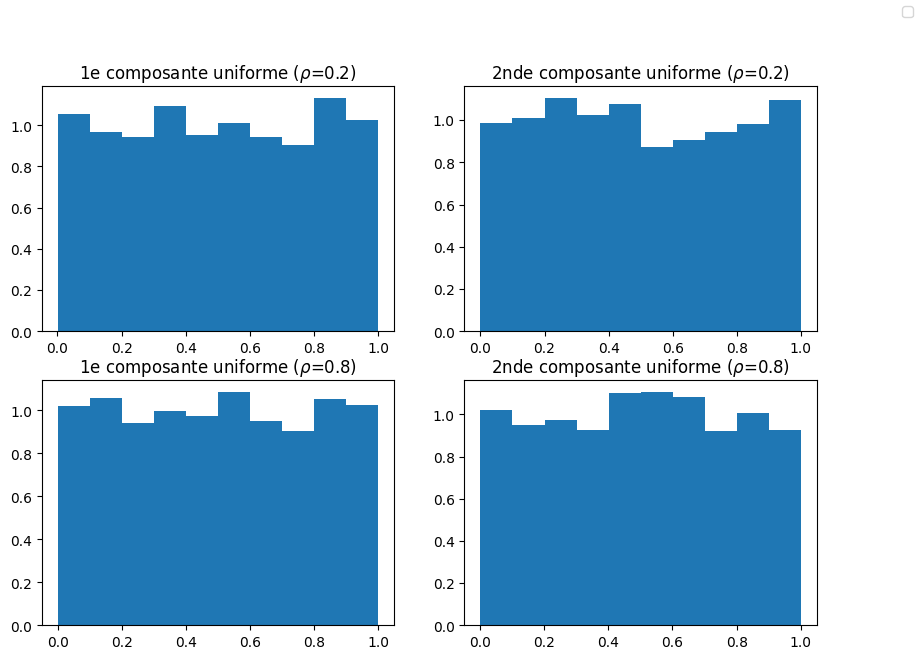

In [4]:
fig, axs = plt.subplots(2,2, figsize=(10,7))

axs[0,0].hist(sample_u_copule1[0], density=True)
axs[0,0].set_title(fr'1e composante uniforme ($\rho$={rho1})')
axs[0,1].hist(sample_u_copule1[1], density=True)
axs[0,1].set_title(fr'2nde composante uniforme ($\rho$={rho1})')

axs[1,0].hist(sample_u_copule2[0], density=True)
axs[1,0].set_title(fr'1e composante uniforme ($\rho$={rho2})')
axs[1,1].hist(sample_u_copule2[1], density=True)
axs[1,1].set_title(fr'2nde composante uniforme ($\rho$={rho2})')

fig.legend()
fig.show()

On revient maintenant au problème des instants de défaut dont on rappelle que $\tau_i \sim \mathcal{E}(\lambda_i)$. On s'intéresse à la variable aléatoire 

$$
    X = \sum_{i = 1}^n \mathbf{1}_{\tau_i \le 1}.
$$

C'est donc une **variable aléatoire discrète** à valeurs dans $\{0,\dots,n \}$. 

### Question: simulation des instants de défaut

Ecrire une fonction (avec les arguments adhoc) pour simuler un échantillon de $X$.  
On utilise dans la suite $n =20$ instants de défaut et $\lambda_i = 0.4$ pour tout $i \in \{1,\dots,n\}$.

In [5]:
def simu_X(size :int, rho :float, n :int=20, lmbda : float=0.4):
    U = copule_gauss(size, n, rho)
    tau = -np.log(U)/lmbda
    return np.sum(tau<=1, axis=0)


### Question: création d'un ensemble de scénarios `samples`

Créer un vecteur `rhos` de taille 4 avec les valeurs $(0,0.2,0.6,0.8)$ et créer une matrice `samples` de 4 lignes et 20000 colonnes, dont chaque ligne sera remplie par des simulations de $X$ pour une valeur de `rho` donnée.
Remplir cette matrice avec réalisations de $X$. Il faut que les éléments de la matrice `sample` soit de type entier `np.int64`.

Cette matrice sera utilisée dans la suite pour le calcul de la moyenne et le tracé des histogrammes.  

In [6]:
rhos = [0, 0.2, 0.6, 0.8]
size = 20_000
n = 20
lmbda = 0.4

samples = np.empty((len(rhos),size), dtype=np.int64)

for k,r in enumerate(rhos) :
    samples[k] = simu_X(size=size, rho=r)    

### Question: calcul de la moyenne 

Calculer (mathématiquement) $\mathbf{E}[X]$ en fonction de $\rho$ et vérifier ce résultat en calculant la moyenne empirique de chaque ligne de la matrice `samples` des réalisations de $X$.

In [7]:
# E[X]  = Somme de 0 à n de P(tau_i <= 1)
#       = Somme de 0 à n de 1-exp(-lmbda_i*1)
#       = n * (1 - exp(-lmbda_i))
#       = 20*(1-exp(-0.4))
moy_math = n*(1-np.exp(-lmbda))
print("Espérence mathématique de X : ", moy_math)

moy_emp = np.mean(samples, axis=1)
print(f'Moyenne empirique selon les différents rho : {moy_emp}')

Espérence mathématique de X :  6.5935990792872134
Moyenne empirique selon les différents rho : [6.58025 6.6038  6.59695 6.61865]


### Question: représentation graphique de `samples` 

![](img/empirical_X.png)

/tmp/ipykernel_9549/3575057148.py:23: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


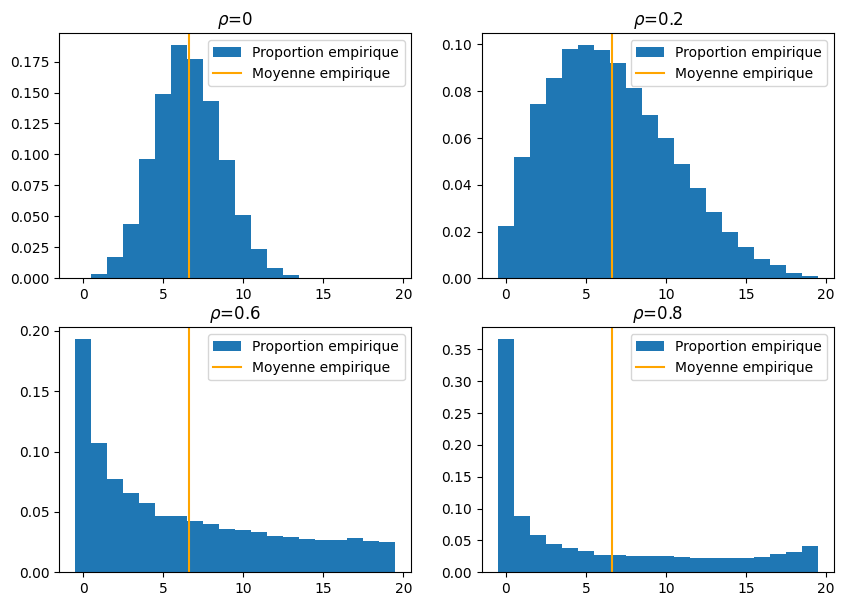

In [8]:
fig, axs = plt.subplots(2,2, figsize=(10,7))

axs[0,0].hist(samples[0], bins=np.arange(-0.5, 20.5, 1), density=True, label="Proportion empirique")
axs[0,0].axvline(moy_math, label="Moyenne empirique", color="orange")
axs[0,0].set_title(fr'$\rho$={rhos[0]}')
axs[0,0].legend()

axs[0,1].hist(samples[1], bins=np.arange(-0.5, 20.5, 1), density=True, label="Proportion empirique")
axs[0,1].axvline(moy_math, label="Moyenne empirique", color="orange")
axs[0,1].set_title(fr'$\rho$={rhos[1]}')
axs[0,1].legend()

axs[1,0].hist(samples[2], bins=np.arange(-0.5, 20.5, 1), density=True, label="Proportion empirique")
axs[1,0].axvline(moy_math, label="Moyenne empirique", color="orange")
axs[1,0].set_title(fr'$\rho$={rhos[2]}')
axs[1,0].legend()

axs[1,1].hist(samples[3], bins=np.arange(-0.5, 20.5, 1), density=True, label="Proportion empirique")
axs[1,1].axvline(moy_math, label="Moyenne empirique", color="orange")
axs[1,1].set_title(fr'$\rho$={rhos[3]}')
axs[1,1].legend()

fig.show()

## Simulation d'une chaîne de Markov: Urnes d'Ehrenfest

On considère $d$ balles ($d > 1$) numérotées de 1 à $d$ et réparties initialement dans deux urnes $A$ et $B$. On note $E = \{1,\dots,d\}$ l'ensemble des balles et on s'intéresse à l'évolution du contenu des urnes après un nombre $n \ge 1$ de changements d'états. Un changement d'état est modélisé de la façon suivante: "_on tire un numéro de balle selon la loi uniforme sur $E$ et à un tirage $i$ on déplace la balle numéro $i$ d'une urne à l'autre_". Le contenu des urnes change au cours du temps et on note $A_n$ le contenu de $A$ à l'itération $n$ (de même $B_n$ est le contenu de $B$ au temps $n$). Ce modèle porte le nom d'[Urnes d'Ehrenfest](https://fr.wikipedia.org/wiki/Mod%C3%A8le_des_urnes_d%27Ehrenfest). 

Dans le programme de test on prendra $d = 20$ c'est à dire $E = \{1,\dots,20\}$ et le contenu initial $A_0 = \{1,\dots,10\}$. 

### Approche naïve

On commence par une approche naïve qui consiste à programmer l'évolution du contenu de l'urne. Si on s'intéresse uniquement au nombre de balles dans chaque urne, il est plus commode d'utiliser la propriété de Markov du système, aussi bien pour l'étude mathématique que pour la programmation.

#### Question: pour manipuler le type `list`

En utilisant le type `list` initaliser les listes `E` et `A_0`, puis programmer l'évolution du contenu de l'urne pas à pas (par exemple en utilisant les méthodes `remove` et `append`). Afficher le résultat `A_n` et `B_n` après `n = 100` itérations.

In [9]:
d=20
n=100

E = [i for i in range(1,d+1)]
A_0 = [i for i in range(1,11)]
B_0 = [i for i in range(11,21)]
print("E : ", E, "\nA_0 : ", A_0 ,"\nB_0 : ", B_0)

A_n = list(A_0)
B_n = list(B_0)

for k in range(n):
    i = rng.choice(E)
    if A_n.count(i)==1:
        A_n.remove(i)
        B_n.append(i)
    elif B_n.count(i)==1:
        B_n.remove(i)
        A_n.append(i)

print("\nA_n : ", A_n ,"\nB_n : ", B_n)

E :  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20] 
A_0 :  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10] 
B_0 :  [11, 12, 13, 14, 15, 16, 17, 18, 19, 20]

A_n :  [1, 17, 19, 12, 2, 14, 20, 4, 9, 18] 
B_n :  [11, 8, 13, 5, 6, 16, 15, 10, 7, 3]


#### Question: pour manipuler le type `set`

Reprendre la question précédente avec le type `set` et les méthodes associées: `add` et `remove`.

In [10]:
E = {i for i in range(1,d+1)}
A_0 = {i for i in range(1,11)}
B_0 = E-A_0
print("E : ", E, "\nA_0 : ", A_0 ,"\nB_0 : ", B_0)

A_n = set(A_0)

for k in range(n):
    i = rng.choice(list(E))
    if i in A_n:
        A_n.remove(i)
    else:
        A_n.add(i)

B_n = E-A_n
print("\nA_n : ", A_n ,"\nB_n : ", B_n)

E :  {1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20} 
A_0 :  {1, 2, 3, 4, 5, 6, 7, 8, 9, 10} 
B_0 :  {11, 12, 13, 14, 15, 16, 17, 18, 19, 20}

A_n :  {4, 13, 2, 7, 1, 9, 14, 10, 3, 17, 19, 16} 
B_n :  {5, 6, 8, 11, 12, 15, 18, 20}


#### Question facultative

Cette construction itérative nécessaire dans des dynamiques plus complexes peut être améliorée de la façon suivante. Si on construit un vecteur `sample` des `n` réalisations de la loi uniforme sur $E$, on peut en déduire directement la composition des urnes à l'itération $n$. En effet la balle $i$ n'a pas changé d'urne entre 0 et $n$ si et seulement si le numéro $i$ apparait un nombre pair de fois dans `sample`.

Construire directement `A_n` et `B_n` à partir d'un vecteur `sample` de taille `n` qui contient les réalisations de la loi uniforme sur $E$.

In [11]:
sample = np.random.randint(1,d,n)
sample

array([ 7,  5, 11,  3,  3,  1, 11,  1,  1,  5,  3,  4,  5,  4, 18, 16,  4,
       14,  4, 12,  2, 17,  8, 15, 15,  3,  2,  3,  6,  8,  2, 13, 15,  4,
       17, 17, 12, 16,  3, 18,  1, 15,  7,  4,  8, 19,  3,  8, 19, 15, 18,
       16, 13, 19, 18, 13,  5, 11, 10, 18,  8,  4, 16,  7,  8, 15,  8,  3,
       13,  4,  2,  7, 14,  1,  7, 19,  4, 17, 19,  9, 10, 17,  5, 17,  7,
        6,  8, 11,  2, 12, 14, 14,  6, 16, 16,  9, 15,  4, 12, 13])

### Modélisation en tant que chaîne de Markov

On s'intéresse maintenant non plus à la composition de l'urne $A_n$ mais uniquement à sa taille. On note $X_n = \mathrm{Card}(A_n)$. L'évolution de $X_n$ se fait de la façon suivante: si l'urne $A_n$ contient $X_{n}$ balles alors la probabilité de tirer une balle présente dans $A_n$ est $\frac{X_{n}}{d}$. Ainsi avec probabilité $\frac{X_{n}}{d}$, $X_{n+1} = X_n - 1$ (car on déplace la balle dans l'urne $B$), et avec probabilité $\frac{d-X_n}{d}$ on a $X_{n+1} = X_n + 1$. La récurrence aléatoire suivante permet de construire une trajectoire $(X_0, \dots, X_n)$ 

$$
    \forall k \ge 0, \quad X_{k+1} = X_k + 1 - 2 \mathbf{1}_{ \left\{U_{k+1} < \frac{X_k}{d} \right\}}, \qquad X_0 \in \{0,\dots,d\},
$$

avec $(U_k)_{k \ge 1}$ une suite de variables aléatoires indépendantes de loi uniforme sur $[0,1]$.

#### Question: simulation de $N$ trajectoires 

Ecrire une fonction qui permet de simuler $N$ trajectoires indépendantes $(X_0^{(j)},\dots, X_n^{(j)})_{1 \le j \le N}$ de la dynamique précédente, et qui renvoie donc un `np.array` de dimension `(N, n+1)` qui contient ces trajectoires. A vous déterminer les arguments de cette fonction.

In [12]:
d = 20

def ehrenfest(x0, n, N):
    u = rng.random(size=(N,n))
    sample = np.empty(shape=(N,n+1), dtype=np.int64)
    sample[:,0] = x0
    for i in range(n):
        sample[:,i+1] = sample[:,i] + 1-2*(u[:,i]<sample[:,i]/d)
    #sample[:,1:] = sample[:,:-1] + 1-2*(u<sample[:,:-1]/d)
    return sample

#### Question: affichage de trajectoires 

Reproduire le graphe suivant qui représente l'évolution de 5 trajectoires de $(X_k)_{0 \le k \le n}$ avec $n=20$. 

![](img/paths.png)

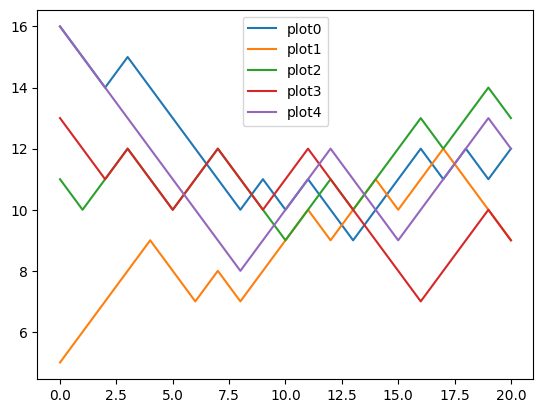

In [13]:
n=20
N=5
x0 = np.random.randint(d,size=N)
traj = ehrenfest(x0,n,N)

support = np.linspace(0,n,n+1)

plt.plot(support, traj[0], label="plot0")
plt.plot(support, traj[1], label="plot1")
plt.plot(support, traj[2], label="plot2")
plt.plot(support, traj[3], label="plot3")
plt.plot(support, traj[4], label="plot4")

plt.legend()
plt.show()

#### Question: représentation de la loi après $n$ itérations 

Représenter la distribution empirique de $(X^{(j)}_n)_{1 \le j \le N}$ pour $N=100\,000$ et deux valeurs de $n$, $n = 100$ puis $n = 101$. Que remarque-t-on? Etait-ce prévisible? 

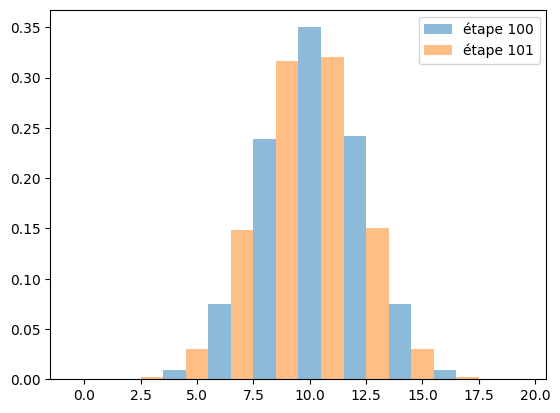

In [14]:
n=101
N=100_000
x0 = 10
traj = ehrenfest(x0,n,N)

plt.hist(traj[:,100], bins=np.arange(-0.5,20.5,1), density=True, label="étape 100", alpha=0.5)
plt.hist(traj[:,101], bins=np.arange(-0.5,20.5,1), density=True, label="étape 101", alpha=0.5)

plt.legend()
plt.show()

#### Question: modification de la dynamique

On modifie un peu la modélisation précédente en considérant la règle suivante: _"on tire un numéro de balle selon la loi uniforme sur $E$ et à un tirage $i$ on déplace la balle numéro $i$ d'une urne à l'autre **avec probabilité 1/2**"_.

Refaire les questions précédentes avec ce nouveau modèle.
On peut montrer que si $X_{n} \sim \mathcal{B}\bigl(d, \frac{1}{2}\bigr)$ (loi binomiale) alors $X_{n+1} \sim \mathcal{B}\bigl(d, \frac{1}{2}\bigr)$. On dit que la loi binomiale $\mathcal{B}\bigl(d, \frac{1}{2}\bigr)$ est invariante pour la chaine de Markov. De plus pour toute configuration initiale $X_0$ la chaine $(X_n)_{n \ge 0}$ converge en loi vers cette mesure invariante $\mathcal{B}\bigl(d, \frac{1}{2}\bigr)$. On veut illustrer cette convergence.

Comparer cette loi binomiale avec l'histogramme empirique de la loi $X_n$ pour $n$ grand (par exemple $n = 100$, vous pouvez choisir $X_0$ fixé à 10).

In [15]:
def ehrenfest_v2(x0, n, N):
    u = rng.random(size=(N,2,n))
    sample = np.empty(shape=(N,n+1), dtype=np.int64)
    sample[:,0] = x0
    for i in range(n):
        sample[:,i+1] = sample[:,i] + (1-2*(u[:,0,i]<sample[:,i]/d))*(u[:,1,i]<0.5)
    #sample[:,1:] = sample[:,:-1] + 1-2*(u<sample[:,:-1]/d)
    return sample

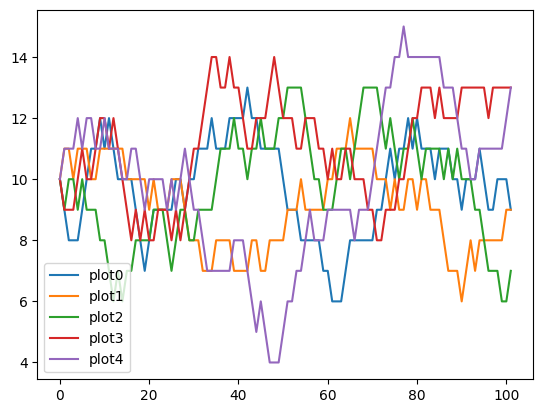

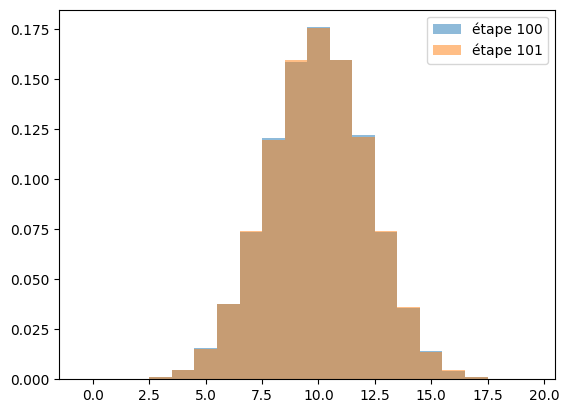

In [16]:
n=101
N=100_000
x0 = 10
traj = ehrenfest_v2(x0,n,N)

support = np.linspace(0,n,n+1)

plt.plot(support, traj[0], label="plot0")
plt.plot(support, traj[1], label="plot1")
plt.plot(support, traj[2], label="plot2")
plt.plot(support, traj[3], label="plot3")
plt.plot(support, traj[4], label="plot4")

plt.legend()
plt.show()


plt.hist(traj[:,100], bins=np.arange(-0.5,20.5,1), density=True, label="étape 100", alpha=0.5)
plt.hist(traj[:,101], bins=np.arange(-0.5,20.5,1), density=True, label="étape 101", alpha=0.5)

plt.legend()
plt.show()

## Processus de Poisson 

On considère un processus de Poisson de paramètre (ou intensité) $\lambda > 0$, c'est à dire un processus de comptage associé à un processus ponctuel $(T_n)_{n \ge 1}$ où les variables aléatoires $T_n$ (appelées instants de sauts) sont définies par
\begin{equation*}
    \forall n \ge 1, \quad T_n - T_{n-1} = S_n, \qquad \text{en posant $T_0 = 0$}
\end{equation*}
avec $(S_n)_{n \ge 1}$ suite _i.i.d._ de loi exponentielle de paramètre $\lambda > 0$.

Pour tout $t \ge 0$, on définit 
\begin{equation*}
    N_t = \sum_{n \ge 0} \mathbf{1}_{T_n \le t},
\end{equation*}
et on veut simuler une trajectoire de $(N_t)_{t \in [0,T]}$ pour un horizon  $T > 0$ fixé. 

### Question: simulation de trajectoires 

Ecrire une fonction `one_poisson_path(lambd, T)` qui renvoie les instants $(T_0, \dots, T_n)$ d'un processus de Poisson d'intensité `lambd` restreint à $[0, T]$. Par convention, on veut que le dernier point du tableau renvoyé soit $T$.  
Reproduire le tracé suivant.  
![](img/poisson.png)

In [17]:
def one_poisson_path(lambd, T):
    inst_sauts = np.zeros(1)
    Tn = 0

    while Tn < T:
        Tn += rng.exponential(scale=1/lambd)
        inst_sauts = np.append(inst_sauts, Tn)
    
    inst_sauts[-1] = T
    return inst_sauts

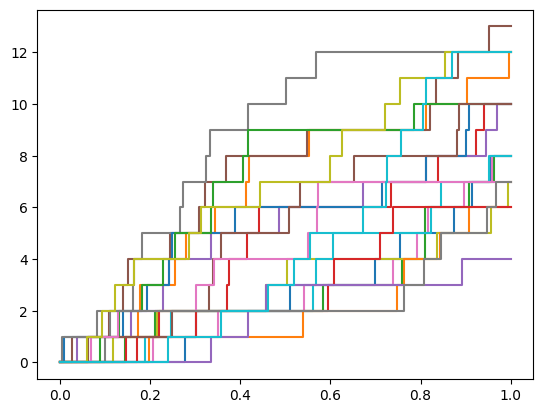

In [58]:
T = 1
lambd = 10
n = 20

for i in range(n):
    inst_sauts = one_poisson_path(lambd, T)
    Nt = np.append(np.arange(len(inst_sauts)-1), len(inst_sauts)-2)     # permet de ne pas considérer le dernier saut
    plt.step(inst_sauts, Nt, where='post')

plt.show()

### Question: simulation alternative 

On rappelle que si $(N_t)_{t \ge 0}$ est un processus de Poisson d'intensité $\lambda > 0$, alors conditionnellement à l'événement $N_T = n$ les instants de sauts $(T_k)_{k=1,\dots,n}$ (tels que $0 < T_1 < \dots < T_n \le T$) ont même loi que le réordonnement croissant d'un vecteur $(U_1, \dots, U_n) \sim \mathcal{U}([0,T]^n)$.

Reprendre la question précédente en utilisant cette propriété. 